In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [3]:
import torch
from torch import nn
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu121
GPU available: 1


In [4]:
# For Creating Dataloaders
from torch.utils.data import Dataset, DataLoader

In [5]:
# For Vision-ML model
import torchvision
from torchvision import transforms, models
from torchvision.transforms import v2
from torchvision.models import video as ptv

In [6]:
# For Deep Neural Network
import torch.nn.functional as F
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU, Flatten, Sequential

In [7]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 96.9 MB/s eta 0:00:00


In [8]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [9]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor

# For TPU
from transformers import set_seed
from torch.optim import AdamW
from accelerate import Accelerator, notebook_launcher

In [10]:
# For Display
from tqdm.notebook import tqdm
from torchsummary import summary

In [11]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

import random
import cv2
import os
import PIL
import gc
from glob import glob
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Initialise Global Constants

In [12]:
output_dir = '/kaggle/working'
data_dir = '/kaggle/input/indian-sign-language-words-with-landmarks'
image_dir = '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit'

In [13]:
BATCH_SIZE = 16
print('BATCH_SIZE =',BATCH_SIZE)

IMAGE_PROCESSOR = 'google/vivit-b-16x2'
WEIGHTS = 'KINETICS400_V1'

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of pretrained model = 32
print('Number of Frames =',CLIP_LENGTH)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

SEED = 42

BATCH_SIZE = 16
Number of Frames = 32
Image Dimension = 224 X 224


In [14]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [15]:
seed_everything(SEED)

# Import metadata

In [16]:
classes = sorted(os.listdir(image_dir))
print(classes)

['afternoon', 'animal', 'bad', 'beautiful', 'big', 'bird', 'blind', 'cat', 'cheap', 'clothing', 'cold', 'cow', 'curved', 'deaf', 'dog', 'dress', 'dry', 'evening', 'expensive', 'famous', 'fast', 'female', 'fish', 'flat', 'friday', 'good', 'happy', 'hat', 'healthy', 'horse', 'hot', 'hour', 'light', 'long', 'loose', 'loud', 'minute', 'monday', 'month', 'morning', 'mouse', 'narrow', 'new', 'night', 'old', 'pant', 'pocket', 'quiet', 'sad', 'saturday', 'second', 'shirt', 'shoes', 'short', 'sick', 'skirt', 'slow', 'small', 'suit', 'sunday', 't_shirt', 'tall', 'thursday', 'time', 'today', 'tomorrow', 'tuesday', 'ugly', 'warm', 'wednesday', 'week', 'wet', 'wide', 'year', 'yesterday', 'young']


In [17]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(image_dir, label)
  if os.path.exists(data_dir):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [18]:
print(label_to_idx)

{'afternoon': 0, 'animal': 1, 'bad': 2, 'beautiful': 3, 'big': 4, 'bird': 5, 'blind': 6, 'cat': 7, 'cheap': 8, 'clothing': 9, 'cold': 10, 'cow': 11, 'curved': 12, 'deaf': 13, 'dog': 14, 'dress': 15, 'dry': 16, 'evening': 17, 'expensive': 18, 'famous': 19, 'fast': 20, 'female': 21, 'fish': 22, 'flat': 23, 'friday': 24, 'good': 25, 'happy': 26, 'hat': 27, 'healthy': 28, 'horse': 29, 'hot': 30, 'hour': 31, 'light': 32, 'long': 33, 'loose': 34, 'loud': 35, 'minute': 36, 'monday': 37, 'month': 38, 'morning': 39, 'mouse': 40, 'narrow': 41, 'new': 42, 'night': 43, 'old': 44, 'pant': 45, 'pocket': 46, 'quiet': 47, 'sad': 48, 'saturday': 49, 'second': 50, 'shirt': 51, 'shoes': 52, 'short': 53, 'sick': 54, 'skirt': 55, 'slow': 56, 'small': 57, 'suit': 58, 'sunday': 59, 't_shirt': 60, 'tall': 61, 'thursday': 62, 'time': 63, 'today': 64, 'tomorrow': 65, 'tuesday': 66, 'ugly': 67, 'warm': 68, 'wednesday': 69, 'week': 70, 'wet': 71, 'wide': 72, 'year': 73, 'yesterday': 74, 'young': 75}


In [19]:
print(idx_to_label)

{0: 'afternoon', 1: 'animal', 2: 'bad', 3: 'beautiful', 4: 'big', 5: 'bird', 6: 'blind', 7: 'cat', 8: 'cheap', 9: 'clothing', 10: 'cold', 11: 'cow', 12: 'curved', 13: 'deaf', 14: 'dog', 15: 'dress', 16: 'dry', 17: 'evening', 18: 'expensive', 19: 'famous', 20: 'fast', 21: 'female', 22: 'fish', 23: 'flat', 24: 'friday', 25: 'good', 26: 'happy', 27: 'hat', 28: 'healthy', 29: 'horse', 30: 'hot', 31: 'hour', 32: 'light', 33: 'long', 34: 'loose', 35: 'loud', 36: 'minute', 37: 'monday', 38: 'month', 39: 'morning', 40: 'mouse', 41: 'narrow', 42: 'new', 43: 'night', 44: 'old', 45: 'pant', 46: 'pocket', 47: 'quiet', 48: 'sad', 49: 'saturday', 50: 'second', 51: 'shirt', 52: 'shoes', 53: 'short', 54: 'sick', 55: 'skirt', 56: 'slow', 57: 'small', 58: 'suit', 59: 'sunday', 60: 't_shirt', 61: 'tall', 62: 'thursday', 63: 'time', 64: 'today', 65: 'tomorrow', 66: 'tuesday', 67: 'ugly', 68: 'warm', 69: 'wednesday', 70: 'week', 71: 'wet', 72: 'wide', 73: 'year', 74: 'yesterday', 75: 'young'}


In [20]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(image_dir, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [21]:
print('input path size:', len(video_path))
print(video_path[:20])

input path size: 1166
['/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5512.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5064.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5511.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_4656.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_4657.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5513.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5514.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_4655.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/ProcessedData_vivit/afternoon/MVI_5063.MOV', '/kaggle/input/indian-sign-language-words-with-landmarks/Pr

In [22]:
print('labels size:', len(labels_int))
print(labels_int[:20])

labels size: 1166
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
print('labels size:', len(labels_text))
print(labels_text[:20])

labels size: 1166
['afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal']


# Train test split

In [24]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=SEED)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=SEED)

In [25]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
print('Test data size:',len(test_path))

Train data size: 745
Val data size: 234
Test data size: 187


In [26]:
train_label[:5]

[54, 28, 25, 52, 5]

# Create Dataset

In [27]:
image_processor = VivitImageProcessor.from_pretrained(IMAGE_PROCESSOR, attn_implementation="sdpa", torch_dtype=torch.float16)

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [28]:
class CreateDataset(Dataset):
    def __init__(self, clip_length, image_processor, video_paths, labels, training=True):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor

        self.video_paths = video_paths
        self.labels = labels
        self.training = training

        # Define a transformation pipeline
        self.transform_train = v2.Compose([
                                    v2.ToImage(),
                                    v2.RandomPerspective(),
                                    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05),
                                    v2.ToDtype(torch.uint8, scale=False)
                                ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):

        # Read the Videos and Labels
        vr = VideoReader(self.video_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Process the video
        video = vr.get_batch(list(range(len(vr))))
        video = video[:self.clip_length]
        if self.training:
            # Data Preperation for ML model with Augmentation
            video = self.transform_train(video.permute(0, 3, 1, 2))
        else:
            # Data Preperation for ML Model without Augmentation
            video = v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)

        # Scaling the video to ML model's desired format
        video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')
        pixel_values = video['pixel_values'].squeeze(0)
        pixel_values = pixel_values.permute(1, 0, 2, 3)

        del vr, video
        gc.collect()

        return {
                'labels': label,
                'pixel_values': pixel_values
                }

In [29]:
train_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=True,
                         video_paths=train_path,
                         labels=train_label
                         )
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
val_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=False,
                         video_paths=val_path,
                         labels=val_label
                         )
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [31]:
test_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=True,
                         video_paths=test_path,
                         labels=test_label
                         )
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Testing custome image processing

In [32]:
# Convert images to numpy for visualization
def imgshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

inputs shape:  torch.Size([16, 3, 32, 224, 224]) torch.Size([16])
label tensor(56)


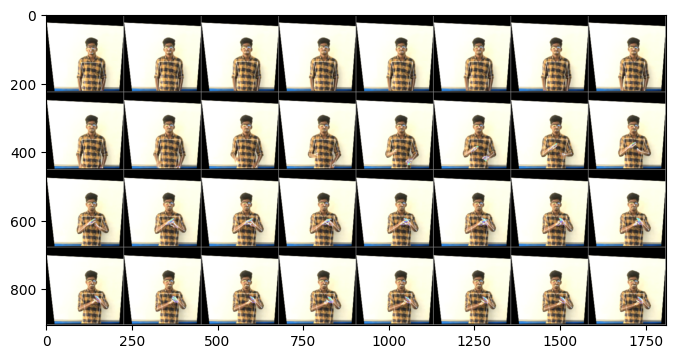

In [33]:
inputs = next(iter(train_dl))
inp_pixel = inputs['pixel_values']
inp_label = inputs['labels']
print('inputs shape: ',inp_pixel.shape, inp_label.shape)
print('label',inp_label[0])
imgshow(torchvision.utils.make_grid(inp_pixel.permute(0, 2, 1, 3, 4)[0]))

inputs shape:  torch.Size([16, 3, 32, 224, 224]) torch.Size([16])
label tensor(43)


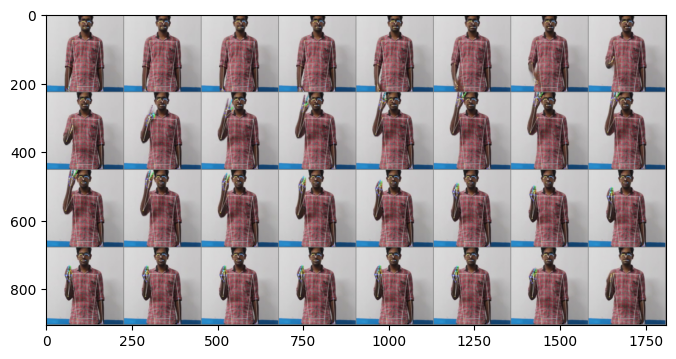

In [34]:
inputs = next(iter(val_dl))
inp_pixel = inputs['pixel_values']
inp_label = inputs['labels']
print('inputs shape: ',inp_pixel.shape, inp_label.shape)
print('label',inp_label[0])
imgshow(torchvision.utils.make_grid(inp_pixel.permute(0, 2, 1, 3, 4)[0]))

inputs shape:  torch.Size([16, 3, 32, 224, 224]) torch.Size([16])
label tensor(56)


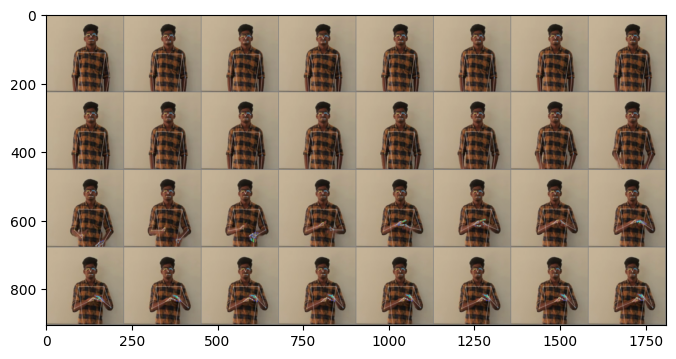

In [35]:
inputs = next(iter(test_dl))
inp_pixel = inputs['pixel_values']
inp_label = inputs['labels']
print('inputs shape: ',inp_pixel.shape, inp_label.shape)
print('label',inp_label[0])
imgshow(torchvision.utils.make_grid(inp_pixel.permute(0, 2, 1, 3, 4)[0]))

# Testing model structure

In [36]:
#sample_model_1 = ptv.swin3d_s(weights=WEIGHTS).to(device)

In [37]:
#summary(sample_model_1, (3,32,224,224))

In [38]:
#sample_model_1

In [39]:
## Freeze all layers initially
#for param in sample_model_1.parameters():
#    param.requires_grad = False

In [40]:
#sample_model_1.features[6][1]

In [41]:
## Un-freeze only the last sequential layer
#for param in sample_model_1.features[6][1].parameters():
#    param.requires_grad = True

In [42]:
#summary(sample_model_1, (3,32,224,224))

# Model Building

In [43]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": SEED,
    "patience": 10, # early stopping
    "output_dir_pt": f"{output_dir}/swin_small_ISL_gpu_pt_1.pt",
    "attention_dropout": 0.2,
    "dropout_rate": 0.2,
    "num_classes": len(classes),
    #"norm_layer": nn.LayerNorm(normalized_shape=torch.Tensor([3])) # normalized_shape =. number of channels
}

In [44]:
class SwinTClassifications(nn.Module):
    def __init__(self,classes, weights="DEFAULT"):
        super().__init__()
        self.classes = classes
        self.weights = weights
        # Load pre-trained model
        self.base_model = ptv.swin3d_s(weights=self.weights,
                                       #dropout=hyperparameters['dropout_rate'],
                                       #attention_dropout=hyperparameters['attention_dropout'],
                                       #norm_layer=hyperparameters['norm_layer'],
                                       )

        # Update the Classification layer to have 76 classes
        #self.base_model.head = torch.nn.Linear(self.base_model.head.in_features , len(self.classes))
        self.classification_head = nn.Sequential(torch.nn.Linear(self.base_model.head.in_features , len(self.classes)),
                                             #nn.Softmax(dim=1)
                                             )

        # Remove the classification head
        self.base_model.head = nn.Identity()

        ## Enable gradient checkpointing to save memory
        #self.base_model.gradient_checkpointing_enable()

        # Freeze all layers initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Un-Freeze the last Sequential layer
        for param in self.base_model.features[6][1].parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.base_model(x)  # Feature extraction
        x = self.classification_head(x)
        return x  # Return classes

In [45]:
def training_function():
    # Initialize accelerator with fp16 if available
    accelerator = Accelerator() #mixed_precision="fp16"

    # Instantiate the model and config
    embedding_model = SwinTClassifications(classes=classes, weights=WEIGHTS)
    #embedding_model = ptv.swin3d_t(weights=WEIGHTS,
    #                               dropout=hyperparameters['dropout_rate'],
    #                               num_classes=hyperparameters['num_classes'],
    #                               attention_dropout=hyperparameters['attention_dropout'],
    #                               norm_layer=hyperparameters['norm_layer'])

    # Set seed
    set_seed(hyperparameters["seed"])

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Filter parameters to include only the ones that require gradients
    #trainable_params = [p for p in embedding_model.parameters() if p.requires_grad]
    optimizer = AdamW(embedding_model.parameters(), lr=hyperparameters["learning_rate"])
    #optimizer = AdamW(trainable_params.parameters(), lr=hyperparameters["learning_rate"])

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # Prepare objects with the accelerator
    accelerated_model, accelerated_optimizer, accelerated_criterion, accelerated_train_dl, accelerated_val_dl = accelerator.prepare(
        embedding_model, optimizer, criterion, train_dl, val_dl
    )

    accelerator.print(summary(accelerated_model, ((3, 32, 224, 224))))

    # Training loop variables
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
        progress_bar = tqdm(range(len(accelerated_train_dl)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        accelerated_model.train()
        training_loss = []

        for batch in accelerated_train_dl:
            # Extract inputs
            pixel_value = batch['pixel_values']
            label = batch['labels']

            # Forward pass
            outputs = accelerated_model(pixel_value)

            # Compute loss
            train_loss = accelerated_criterion(outputs, label)

            # Backward pass
            accelerator.backward(train_loss)

            # Optimizer step and gradient reset
            accelerated_optimizer.step()
            accelerated_optimizer.zero_grad()

            # Delete unwanted data
            del pixel_value, outputs, label
            gc.collect()

            # Gather loss from all processes
            training_loss.append(accelerator.gather(train_loss[None]))
            progress_bar.set_postfix({'loss': train_loss.detach().item()})
            progress_bar.update(1)

        # Compute average training loss
        training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
        accelerator.print(f"epoch {epoch}: learning rate: {scheduler.get_last_lr()}")
        accelerator.print(f"epoch {epoch}: training loss: {training_loss_final}")

        # Evaluation on validation set
        accelerated_model.eval()
        validation_loss = []
        for batch in accelerated_val_dl:
            # Extract inputs
            pixel_value = batch['pixel_values']
            label = batch['labels']

            with torch.no_grad():
                outputs = accelerated_model(pixel_value)

            # Compute loss
            val_loss = accelerated_criterion(outputs, label)
            validation_loss.append(accelerator.gather(val_loss[None]))

            # Delete unwanted data
            del pixel_value, outputs, label
            gc.collect()

        validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
        accelerator.print(f"epoch {epoch}: validation loss: {validation_loss_final}")

        # Update the learning rate scheduler
        scheduler.step(validation_loss_final)

        # Early stopping and model saving
        if validation_loss_final < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = validation_loss_final
            # Save the model weights as state_dict
            torch.save(accelerated_model.state_dict(), hyperparameters['output_dir_pt'])
        else:
            epochs_no_improve += 1
            if epochs_no_improve == hyperparameters["patience"]:
                accelerator.print("Early stopping!")
                break

In [46]:
# Run the trainer function
training_function()

Downloading: "https://download.pytorch.org/models/swin3d_s-da41c237.pth" to /root/.cache/torch/hub/checkpoints/swin3d_s-da41c237.pth
100%|██████████| 218M/218M [00:12<00:00, 18.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0
  StochasticDepth-14       [-1, 1

  0%|          | 0/47 [00:00<?, ?it/s]

epoch 0: learning rate: [0.0001]
epoch 0: training loss: 4.303253823138298
epoch 0: validation loss: 4.165829976399739


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 4.008333246758643
epoch 1: validation loss: 3.771497599283854


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 3.5500777224276927
epoch 2: validation loss: 3.158807881673177


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0001]
epoch 3: training loss: 3.027267131399601
epoch 3: validation loss: 2.578568522135417


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0001]
epoch 4: training loss: 2.5089703823657747
epoch 4: validation loss: 2.1488942464192706


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0001]
epoch 5: training loss: 2.104041890895113
epoch 5: validation loss: 1.7964122772216797


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 1.8108838669797207
epoch 6: validation loss: 1.547495142618815


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 1.5813215539810506
epoch 7: validation loss: 1.3598103841145834


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 8: learning rate: [0.0001]
epoch 8: training loss: 1.4041879532185007
epoch 8: validation loss: 1.1814402262369792


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 9: learning rate: [0.0001]
epoch 9: training loss: 1.2816877973840592
epoch 9: validation loss: 1.0693398793538411


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 10: learning rate: [0.0001]
epoch 10: training loss: 1.1865628019292305
epoch 10: validation loss: 0.9358715057373047


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 11: learning rate: [0.0001]
epoch 11: training loss: 1.0606671597095245
epoch 11: validation loss: 0.8296679178873698


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 12: learning rate: [0.0001]
epoch 12: training loss: 0.9531280030595496
epoch 12: validation loss: 0.7970586140950521


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 13: learning rate: [0.0001]
epoch 13: training loss: 0.9287352866314827
epoch 13: validation loss: 0.6942210515340169


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 14: learning rate: [0.0001]
epoch 14: training loss: 0.8714690512799202
epoch 14: validation loss: 0.6743411382039388


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 15: learning rate: [0.0001]
epoch 15: training loss: 0.7673102845536902
epoch 15: validation loss: 0.6547948201497396


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 16: learning rate: [0.0001]
epoch 16: training loss: 0.7553864337028341
epoch 16: validation loss: 0.5792919158935547


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 17: learning rate: [0.0001]
epoch 17: training loss: 0.7185813416825965
epoch 17: validation loss: 0.5659254709879558


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 18: learning rate: [0.0001]
epoch 18: training loss: 0.6696852014419881
epoch 18: validation loss: 0.5542462666829427


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 19: learning rate: [0.0001]
epoch 19: training loss: 0.6407443107442653
epoch 19: validation loss: 0.5803974787394206


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 20: learning rate: [0.0001]
epoch 20: training loss: 0.6748889354949302
epoch 20: validation loss: 0.5091448148091634


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 21: learning rate: [0.0001]
epoch 21: training loss: 0.562324767417096
epoch 21: validation loss: 0.5230242093404134


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 22: learning rate: [0.0001]
epoch 22: training loss: 0.5759107711467337
epoch 22: validation loss: 0.4745727221171061


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 23: learning rate: [0.0001]
epoch 23: training loss: 0.5862539981273894
epoch 23: validation loss: 0.4612818400065104


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 24: learning rate: [0.0001]
epoch 24: training loss: 0.5403833592191656
epoch 24: validation loss: 0.42875610987345375


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 25: learning rate: [0.0001]
epoch 25: training loss: 0.5443345333667512
epoch 25: validation loss: 0.40717620849609376


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 26: learning rate: [0.0001]
epoch 26: training loss: 0.5058559661215924
epoch 26: validation loss: 0.3853573481241862


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 27: learning rate: [0.0001]
epoch 27: training loss: 0.513810137484936
epoch 27: validation loss: 0.41776936848958335


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 28: learning rate: [0.0001]
epoch 28: training loss: 0.4975452017276845
epoch 28: validation loss: 0.46976324717203777


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 29: learning rate: [0.0001]
epoch 29: training loss: 0.4688709746015833
epoch 29: validation loss: 0.38773508071899415


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 30: learning rate: [5e-05]
epoch 30: training loss: 0.4193654161818484
epoch 30: validation loss: 0.36601810455322265


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 31: learning rate: [5e-05]
epoch 31: training loss: 0.3780576016040558
epoch 31: validation loss: 0.3441350301106771


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 32: learning rate: [5e-05]
epoch 32: training loss: 0.40073780303305767
epoch 32: validation loss: 0.32931286493937173


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 33: learning rate: [5e-05]
epoch 33: training loss: 0.37748592457872754
epoch 33: validation loss: 0.3267545700073242


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 34: learning rate: [5e-05]
epoch 34: training loss: 0.4460344111665766
epoch 34: validation loss: 0.3132598559061686


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 35: learning rate: [5e-05]
epoch 35: training loss: 0.4106045986743683
epoch 35: validation loss: 0.31767892837524414


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 36: learning rate: [5e-05]
epoch 36: training loss: 0.35859631477518283
epoch 36: validation loss: 0.3218037287394206


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 37: learning rate: [5e-05]
epoch 37: training loss: 0.3570980315512799
epoch 37: validation loss: 0.3153856595357259


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 38: learning rate: [2.5e-05]
epoch 38: training loss: 0.39603306384796794
epoch 38: validation loss: 0.29128475189208985


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 39: learning rate: [2.5e-05]
epoch 39: training loss: 0.3906814899850399
epoch 39: validation loss: 0.28131020863850914


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 40: learning rate: [2.5e-05]
epoch 40: training loss: 0.40278130389274436
epoch 40: validation loss: 0.294676939646403


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 41: learning rate: [2.5e-05]
epoch 41: training loss: 0.395213634409803
epoch 41: validation loss: 0.2982199668884277


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 42: learning rate: [2.5e-05]
epoch 42: training loss: 0.38229978845474566
epoch 42: validation loss: 0.2901312828063965


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 43: learning rate: [1.25e-05]
epoch 43: training loss: 0.3902098473082197
epoch 43: validation loss: 0.280213197072347


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 44: learning rate: [1.25e-05]
epoch 44: training loss: 0.3384273001488219
epoch 44: validation loss: 0.277765146891276


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 45: learning rate: [1.25e-05]
epoch 45: training loss: 0.3436198538922249
epoch 45: validation loss: 0.2778827667236328


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 46: learning rate: [1.25e-05]
epoch 46: training loss: 0.37791377940076465
epoch 46: validation loss: 0.27843761444091797


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 47: learning rate: [1.25e-05]
epoch 47: training loss: 0.37555029037150933
epoch 47: validation loss: 0.2768771807352702


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 48: learning rate: [1.25e-05]
epoch 48: training loss: 0.35632997878054357
epoch 48: validation loss: 0.2735247294108073


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 49: learning rate: [1.25e-05]
epoch 49: training loss: 0.34391293627150515
epoch 49: validation loss: 0.2769682248433431


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 50: learning rate: [1.25e-05]
epoch 50: training loss: 0.42061432371748253
epoch 50: validation loss: 0.2765048027038574


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 51: learning rate: [1.25e-05]
epoch 51: training loss: 0.3211262885560381
epoch 51: validation loss: 0.27375971476236977


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 52: learning rate: [1e-05]
epoch 52: training loss: 0.344739224048371
epoch 52: validation loss: 0.27802314758300783


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 53: learning rate: [1e-05]
epoch 53: training loss: 0.389286163005423
epoch 53: validation loss: 0.28299261728922526


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 54: learning rate: [1e-05]
epoch 54: training loss: 0.3536063255147731
epoch 54: validation loss: 0.28735599517822263


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 55: learning rate: [1e-05]
epoch 55: training loss: 0.3586171332826006
epoch 55: validation loss: 0.2838188489278158


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 56: learning rate: [1e-05]
epoch 56: training loss: 0.32762448331142996
epoch 56: validation loss: 0.27657365798950195


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 57: learning rate: [1e-05]
epoch 57: training loss: 0.3871793138219955
epoch 57: validation loss: 0.2707213401794434


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 58: learning rate: [1e-05]
epoch 58: training loss: 0.3302856404730614
epoch 58: validation loss: 0.274136225382487


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 59: learning rate: [1e-05]
epoch 59: training loss: 0.3064356864766872
epoch 59: validation loss: 0.27313880920410155


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 60: learning rate: [1e-05]
epoch 60: training loss: 0.3514622627420628
epoch 60: validation loss: 0.2713619232177734


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 61: learning rate: [1e-05]
epoch 61: training loss: 0.35218563485652843
epoch 61: validation loss: 0.27749061584472656


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 62: learning rate: [1e-05]
epoch 62: training loss: 0.36108171178939497
epoch 62: validation loss: 0.27590707143147786


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 63: learning rate: [1e-05]
epoch 63: training loss: 0.3662335010285073
epoch 63: validation loss: 0.27473195393880206


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 64: learning rate: [1e-05]
epoch 64: training loss: 0.35413709599921045
epoch 64: validation loss: 0.27383944193522136


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 65: learning rate: [1e-05]
epoch 65: training loss: 0.3375056246493725
epoch 65: validation loss: 0.2757956822713216


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 66: learning rate: [1e-05]
epoch 66: training loss: 0.3357833294158286
epoch 66: validation loss: 0.272630246480306


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 67: learning rate: [1e-05]
epoch 67: training loss: 0.3597224215243725
epoch 67: validation loss: 0.272207514444987
Early stopping!


# Load Model

In [47]:
class SwinTClassifications(nn.Module):
    def __init__(self,classes, weights="DEFAULT"):
        super().__init__()
        self.classes = classes
        self.weights = weights
        # Load pre-trained model
        self.base_model = ptv.swin3d_s(weights=self.weights)

        self.classification_head = nn.Sequential(torch.nn.Linear(self.base_model.head.in_features , len(self.classes)),
                                             #nn.Softmax(dim=1)
                                             )

        # Remove the classification head
        self.base_model.head = nn.Identity()

    def forward(self, x):
        x = self.base_model(x)  # Feature extraction
        x = self.classification_head(x)
        return x  # Return classes

In [48]:
recon_model = SwinTClassifications(classes=classes, weights=WEIGHTS).to(device)
recon_model.load_state_dict(torch.load(hyperparameters['output_dir_pt'], weights_only=True, map_location=device))
recon_model.eval()
print("Entire model loaded successfully!")
print(summary(recon_model, (3, 32, 224, 224)))

Entire model loaded successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0

# Make Predictions

In [49]:
# Now we train the model
def testing_function(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []
    test_outputs = []

    for batch in tqdm(acclerated_test_dl):

        pixel_value = batch['pixel_values']
        test_label = batch['labels']

        with torch.no_grad():
            outputs = accelerated_model(pixel_value)

        test_softmax = torch.nn.functional.softmax(outputs, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_outputs.append(outputs)
        test_labels.append(test_label)

    return test_labels, test_preds, test_outputs


In [50]:
actual_label, predicted_test_label, predicted_test_outputs = testing_function(recon_model)

  0%|          | 0/12 [00:00<?, ?it/s]

# Analyze predictions

In [51]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')
predicted_test_outputs = torch.cat(predicted_test_outputs).to('cpu')

In [52]:
print('predictions',predicted_test_labels.numpy())

predictions [56 44 42  5 57  3 65 17 66 70 10 28 45 16 65 60 38 16 29 40 28 66 53 52
 62 48 51 75 74 69 64 47 58  2 16 23 72 53 11 24 47  1 71 28 57 29 57 49
 35 28 45 54 40 55 27 68  2 36  5 17 58  6 55 15  9 53 14 26 14 74 15 58
  0  1 29 25  7 47 73 75 39  7 24 42 28 10 40 54 35 33 53 62 46 45 56 43
  5 61 61 51 34  1 72 44 60 75 10 66 68 31 22 12 57 46  2 13  4 52 71 52
 22 42 51 14 31 11 20 27  4 21 50 66 49 61 60 28 41  8 15 33 26 27 30 29
 45 37 41 43  5 46 19 72 65  4 32  0 70 35 63  9 63 71 64 56  9 11 71 71
 54  2  3 61 42 70 38 18 44  4 68 20 73  2  4 39 68 33 36]


In [53]:
print(actual_labels)

tensor([56, 20, 42,  1, 57,  3, 36, 17, 66, 70, 10, 30, 45, 16, 65, 60, 38, 16,
        29, 40, 26, 59, 53, 52, 62, 48, 51, 75, 74, 69, 64, 47, 58,  2, 16, 23,
        72, 53, 11, 24, 47,  7, 71, 28, 57, 22, 57, 49, 35, 30, 55, 54, 40, 55,
        27, 44,  2, 36,  5, 17, 58,  6, 55,  9,  9, 53, 14, 26, 14, 74, 15, 58,
         0,  1, 29, 25,  7, 47, 73, 75, 39,  7, 24, 42, 28, 10, 40, 54, 35, 33,
        53, 62, 46, 45, 56, 43,  5, 61, 61, 51, 34,  1, 72, 44, 60, 75, 10, 37,
        68, 31, 22, 12, 57, 46,  2, 13,  4, 52, 71, 52, 22, 42, 51, 14, 31, 11,
        20, 27,  4, 21, 50, 66, 49, 61, 60, 28, 41,  8, 15, 33, 26, 27, 30, 29,
        45, 37, 41, 43,  5, 46, 19, 72, 65,  4, 32,  0, 70, 35, 63, 15, 63, 71,
        64, 56,  9, 11, 25, 71, 54,  2, 67, 61, 42, 69, 38, 18, 44,  4, 68, 20,
        73, 25, 41, 39, 68, 33, 59])


In [54]:
predicted_test_outputs

tensor([[-4.0608, -3.4993,  2.2610,  ..., -2.3445, -4.1628,  5.4623],
        [-1.1885, -3.2484,  2.6847,  ..., -2.7417,  2.9564, -0.0562],
        [-0.5793, -2.2202,  4.2012,  ..., -1.0203,  1.3405,  3.2498],
        ...,
        [ 6.8548, -0.1814, -0.9649,  ..., -3.2002, -0.4962,  3.3489],
        [-4.3558, -5.1588,  2.9741,  ..., -0.7613, -3.6166,  1.5701],
        [-1.1548, -4.5575, -0.8621,  ...,  1.7822,  1.8809, -1.2552]])

In [55]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      0.67      0.67         3
           2       0.80      1.00      0.89         4
           3       0.50      1.00      0.67         1
           4       0.80      1.00      0.89         4
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         1
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         1
           9       0.67      0.67      0.67         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       0.67      0.67      0.67         3
          16       1.00      1.00      1.00         3
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
